# Working with Projections

In [15]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import hamiltonian_symmetry as hsym
import fermi_surface as fs
import kpaths
import qespresso_interface as qe

# read the data from Bandx.dat from Quantum Espresso
material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
k_smpl, ref_bands, symmetries, fermi_energy, A = material.read_bands_crystal()
_, _, projections, overlaps, fermi_energy, electron_number = material.read_projections("./qe-data/nitinol_2_993_atomic_proj.xml")

# remove spin freedom
projections = projections[:,:,0,:]

k_smpl_full, order = Symmetry(symmetries).realize_symmetric(k_smpl)
ref_bands_full = ref_bands[order]

# make the hamiltonian symmetry for the atomic wfcs
hsym_atomic = hsym.HamiltonianSymmetry(Symmetry.cubic(True))
hsym_atomic.append_s([0, 0, 0], "Ni") # s
hsym_atomic.append_p([0, 0, 0], "Ni") # p_x p_y p_z
hsym_atomic.append_d3([0, 0, 0], "Ni") # d_zy d_zx d_xy
hsym_atomic.append_d2([0, 0, 0], "Ni") # d_{z^2} d_{x^2-y^2}
hsym_atomic.append_s([0, 0, 0], "Ni") # s
hsym_atomic.append_s([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_p([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_d3([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_d2([0.5, 0.5, 0.5], "Ti")
hsym_atomic.append_s([0.5, 0.5, 0.5], "Ti")
# both for p and for d orbitals, some reordering is necessary
atomic_order = [0, 3, 4, 2, 5+2, 5+1, 5+4, 5, 5+3, 1]
atomic_order = atomic_order + [x + 10 for x in atomic_order]
projections = projections[:, :, atomic_order]

# print fermi bands for both datasets
print("dataset1:")
print("fermi energy:", fermi_energy)
print("fermi bands:", [i for i, e in enumerate(ref_bands.T) if np.min(e) < fermi_energy and np.max(e) > fermi_energy])

dataset1:
fermi energy: 16.181655905930956
fermi bands: [14, 15]


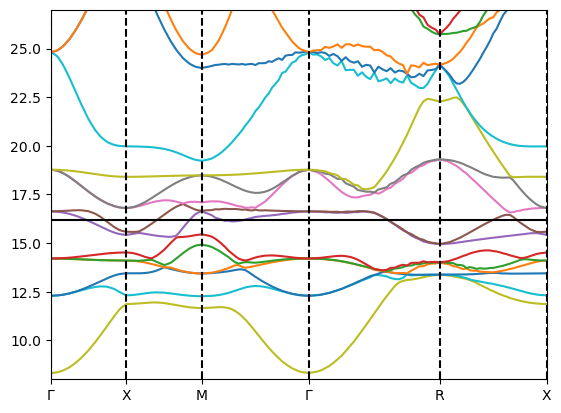

In [16]:
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl_full, ref_bands_full, Symmetry.none(), method='linear')
path.plot(interpolator, '-')
plt.axhline(fermi_energy, color='k')
plt.ylim(8, 27)
plt.show()

In [17]:
index = 90 # 0 = Gamma, 90 = M
print((np.abs(projections[index])**2).sum(1)) # = how well each band is represented
print((np.abs(projections[index])**2).sum(0)) # = how much each atomic orbital is used

[1.    1.    1.    1.    1.    1.    1.    1.    0.998 0.999 0.997 0.997
 1.    0.999 0.    0.    1.    1.    1.    1.    0.977 0.995 0.    0.   ]
[1.    1.    1.    1.    1.    0.998 0.998 0.999 0.999 0.979 1.    1.
 1.    1.    0.997 0.999 0.999 1.    1.    0.994]


In [18]:

#print(np.real(np.linalg.det(projections.conj().swapaxes(-1, -2) @ projections))**.5)
H_k = np.einsum("ndi,nd,ndj->nij", projections, ref_bands, np.conj(projections))
#print(np.shape(H_k)) # number of atomic_wfcs = dimension of the matrix
la, ev = np.linalg.eigh(H_k)
print(la[index])
print(la[index][8])
print(np.abs(ev[index].T[8]))
print(ref_bands[index])

[-87.07  -47.597 -47.597 -47.583 -40.692 -17.204 -17.204 -16.914  11.635
  12.261  13.402  13.402  14.918  15.437  17.09   18.478  18.478  19.229
  23.442  24.553]
11.63548333400052
[0.061 0.    0.    0.    0.    0.    0.    0.286 0.495 0.43  0.    0.
 0.    0.    0.697 0.    0.    0.    0.    0.   ]
[-87.071 -47.6   -47.6   -47.585 -40.692 -17.216 -17.216 -16.914  11.659
  12.268  13.438  13.438  14.924  15.451  16.651  16.651  17.098  18.482
  18.482  19.232  24.002  24.679  31.22   31.94 ]


In [19]:
def print_orbitals(dist):
    orbitals = ["3s", "3p_x", "3p_y", "3p_z", "3d_zy", "3d_zx", "3d_xy", "3d_{z^2}", "3d_{x^2-y^2}", "4s"]
    orbitals = ["Ni " + x for x in orbitals] + ["Ti " + x for x in orbitals]
    order = np.argsort(dist)
    for i in np.flip(order):
        if dist[i] < 0.05:
            break
        print(f"{orbitals[i]}: {dist[i]:.1%}, ", end="")
    print()

index = 0
print(f"bands at point {k_smpl[index]}:")
for band_index in range(len(ref_bands[0])):
    energy_range = np.min(ref_bands[:,band_index]), np.max(ref_bands[:,band_index])
    if energy_range[0] <= fermi_energy and energy_range[1] >= fermi_energy:
        print(f"BAND {band_index}: ", end="")
    else:
        print(f"band {band_index}: ", end="")
    print_orbitals(np.abs(projections[index, band_index])**2)

bands at point [0. 0. 0.]:
band 0: Ni 3s: 92.9%, Ti 4s: 6.9%, 
band 1: Ni 3p_y: 66.0%, Ni 3p_z: 23.2%, Ni 3p_x: 10.7%, 
band 2: Ni 3p_x: 80.4%, Ni 3p_y: 15.3%, 
band 3: Ni 3p_z: 72.4%, Ni 3p_y: 18.6%, Ni 3p_x: 8.9%, 
band 4: Ti 3s: 92.7%, Ni 4s: 6.0%, 
band 5: Ti 3p_z: 100.0%, 
band 6: Ti 3p_y: 77.4%, Ti 3p_x: 22.6%, 
band 7: Ti 3p_x: 77.4%, Ti 3p_y: 22.6%, 
band 8: Ti 4s: 53.3%, Ni 4s: 37.7%, Ti 3s: 6.0%, 
band 9: Ni 3d_{z^2}: 66.1%, Ti 3d_{z^2}: 33.1%, 
band 10: Ni 3d_{x^2-y^2}: 66.1%, Ti 3d_{x^2-y^2}: 33.1%, 
band 11: Ni 3d_xy: 91.5%, Ti 3d_xy: 8.4%, 
band 12: Ni 3d_zx: 58.6%, Ni 3d_zy: 32.9%, Ti 3d_zx: 5.4%, 
band 13: Ni 3d_zy: 58.6%, Ni 3d_zx: 32.9%, Ti 3d_zy: 5.4%, 
BAND 14: Ti 3d_{x^2-y^2}: 66.5%, Ni 3d_{x^2-y^2}: 33.4%, 
BAND 15: Ti 3d_{z^2}: 66.5%, Ni 3d_{z^2}: 33.4%, 
band 16: Ti 3d_zy: 47.2%, Ti 3d_zx: 44.4%, 
band 17: Ti 3d_zx: 47.2%, Ti 3d_zy: 44.4%, 
band 18: Ti 3d_xy: 91.6%, Ni 3d_xy: 8.4%, 
band 19: 
band 20: 
band 21: 
band 22: 
band 23: 


energy range: [14.95eV, 17.01eV]
fermi surface band: True
contributing orbitals
Part with 25.60%:
Ti 3d_{x^2-y^2}: 35.1%, Ni 3d_{x^2-y^2}: 19.3%, Ti 3d_zx: 13.3%, Ti 3d_{z^2}: 13.0%, Ni 3d_{z^2}: 9.2%, Ti 3d_zy: 6.1%, 
Part with 20.36%:
Ti 3d_{z^2}: 27.4%, Ni 3d_{z^2}: 21.8%, Ti 3d_zy: 21.0%, Ni 3d_{x^2-y^2}: 16.2%, Ti 3d_zx: 9.0%, 
Part with 17.63%:
Ti 3d_{x^2-y^2}: 49.6%, Ni 3d_{z^2}: 10.5%, Ti 3d_{z^2}: 10.2%, Ti 3d_zx: 9.0%, Ni 3d_{x^2-y^2}: 7.5%, Ni 3d_zy: 6.2%, 
Part with 10.13%:
Ni 3d_{z^2}: 27.8%, Ti 3d_{z^2}: 25.0%, Ti 3d_zx: 11.1%, Ti 3d_xy: 10.9%, Ni 3d_{x^2-y^2}: 10.0%, Ni 4s: 6.9%, 


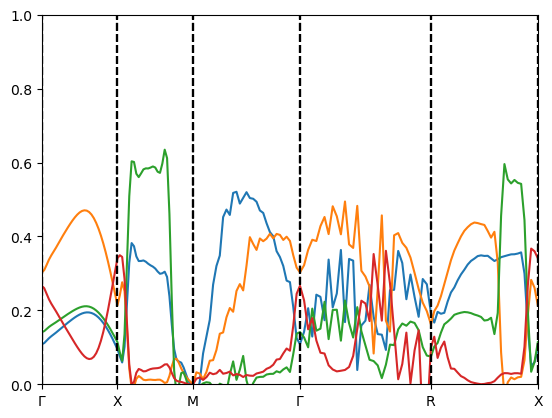

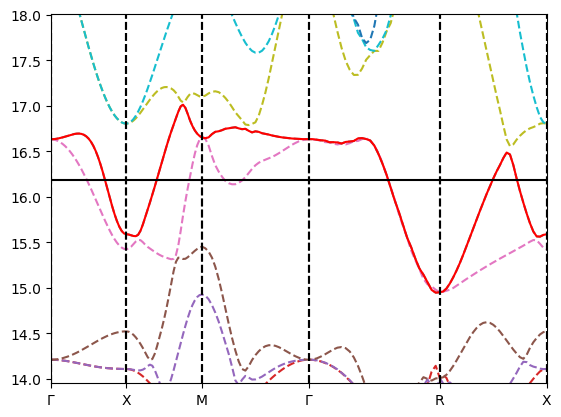

In [20]:
# look at one band
band_index = 15

path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')

# determine which atomic orbitals contribute to it
cov = np.cov(projections[:,band_index,:].T)
la, ev = np.linalg.eigh(cov)
# compute actual size in the Eigen-directions
la = np.sqrt(la)
# normalize the covariance volume
la /= np.sum(la)
energy_range = np.min(ref_bands[:,band_index]), np.max(ref_bands[:,band_index])
print(f"energy range: [{energy_range[0]:.2f}eV, {energy_range[1]:.2f}eV]")
print("fermi surface band:", energy_range[0] <= fermi_energy and energy_range[1] >= fermi_energy)
print("contributing orbitals")
sym = Symmetry.cubic(True)
for i in range(1, len(la)):
    if la[-i] < 0.1:
        break
    print(f"Part with {la[-i]:.2%}:")
    print_orbitals(np.abs(ev.T[-i])**2)
    data = np.abs(np.einsum("nj,j->n", projections[:,band_index,:], ev.T[-i].conj())[:,None])**2
    #print(k_smpl[np.argmin(data.sum(1))])
    #print(np.argmin(data.sum(1)))
    interpolator = kpaths.interpolate(k_smpl_full, data[order], Symmetry.none(), method='cubic')
    path.plot(interpolator, '-', color=f"C{i-1}")

plt.ylim(0, 1)
plt.show()

interpolator = kpaths.interpolate(k_smpl_full, ref_bands_full[:,8:], Symmetry.none(), method='cubic')
path.plot(interpolator, '--')
interpolator = kpaths.interpolate(k_smpl_full, ref_bands_full[:,band_index:band_index+1], Symmetry.none(), method='cubic')
path.plot(interpolator, '-', color='r')
plt.axhline(fermi_energy, color="k")
plt.ylim(energy_range[0]-1, energy_range[1]+1)
plt.show()

Fat band plots
-> Fehlerbalken als Darstellung von Projektion auf ein Band.

Alternative:
    Farben

# Flood-fill Band Identity

Start at Gamma-point and flood fill all band identities by matching their atomic orbital contributions.

For the matching, use a *Closest pair of points problem* solution that is $\mathcal{O}(n^2) \log(n)$ because $n=24$, so it's fine. There exist randomized algorithms better scaling.

Problem: at high symmery points, the eigendecomposition i.e. the band numbering, is not well defined.

In [4]:
import scipy
def matching(a, b):
    assert np.shape(a) == np.shape(b)
    assert len(np.shape(a)) == 2
    a = np.asarray(a)
    b = np.asarray(b)
    n = len(a)
    #point_dim = a.shape[-1]
    # compute all distances
    if len(a[0]) > 1:
        a_vec = a[None,:,:-1]
        b_vec = b[:,None,:-1]
        dot = np.abs((a_vec * b_vec.conj()).sum(-1)) / np.linalg.norm(a_vec, axis=-1) / np.linalg.norm(b_vec, axis=-1)
        d = 1-dot # arccos(dot)**2 ~ 1-dot
    else:
        d = np.zeros((n, n))
    #d = -np.abs((a[None,:,:] * b[:,None,:].conj()).sum(-1))
    #d = np.linalg.norm(np.abs(a[None,:,:]) - np.abs(b[:,None,:]), axis=-1)
    d += 0.5*np.abs(a[None,:,-1] - b[:,None,-1])**2 # distance based on energy difference

    a_ind, b_ind = scipy.optimize.linear_sum_assignment(-d, maximize=True)
    #print(a_ind, b_ind)
    a_inv = np.zeros_like(a_ind)
    a_inv[a_ind] = np.arange(len(a_ind))
    return b_ind[a_inv]


a = np.array([-87.072, -47.588, -47.588, -47.588, -40.752, -16.97 , -16.964,-16.964,   8.353,  12.306,  12.307,  14.206,  14.206,  14.214, 16.616,  16.637,  18.729,  18.729,  18.771,  24.629,  24.893, 24.893,  31.257,  31.4  ])[:,None]
b = np.array([-87.072, -47.589, -47.588, -47.588, -40.75 , -16.985, -16.963,-16.963,   8.455,  12.347,  12.348,  14.2  ,  14.2  ,  14.228, 16.573,  16.654,  18.594,  18.594,  18.753,  24.145,  25.128, 25.128,  31.203,  31.69 ])[:,None]
print(matching([[0, 1, 0], [1, 0, 0], [1, 1, 0]], [[1.1, 0.9, 0], [0, 1.1, 0], [1, 0.1, 0]]))
# 0 -> 1
# 1 -> 2
# 2 -> 0
print(matching(a, b))

[2 0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [5]:
select = (k_smpl[:,0] == 0) & (k_smpl[:,1] == 0)
print(np.arange(len(k_smpl))[select])
#print(np.argmax(np.abs(projections[select]), axis=-1))
x_proj = np.concatenate([projections[:,11:14,:], ref_bands[:,11:14,None]], axis=-1)[select]
#x_proj = ref_bands[select][:,11:14,None]
for i in range(len(x_proj)-1):
    print(i, matching(np.array(x_proj[i]), np.array(x_proj[i+1])), np.real(x_proj[i,:,-1].ravel()))
#print(repr(x_proj[4].ravel()), repr(x_proj[5].ravel()), sep="\n")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
0 [1 2 0] [14.209 14.209 14.209]
1 [0 1 2] [14.206 14.206 14.214]
2 [1 0 2] [14.2   14.2   14.228]
3 [0 1 2] [14.189 14.189 14.251]
4 [0 1 2] [14.176 14.176 14.282]
5 [1 0 2] [14.162 14.162 14.318]
6 [0 1 2] [14.147 14.147 14.358]
7 [1 0 2] [14.135 14.135 14.399]
8 [1 0 2] [14.124 14.124 14.437]
9 [0 1 2] [14.116 14.116 14.471]
10 [0 1 2] [14.111 14.111 14.498]
11 [0 1 2] [14.108 14.108 14.515]


[0.0, 0.041667, 0.058926, 0.072169, 0.083333, 0.093169]
close to zero indices [0, 1, 91, 13]
455/455
complete: True


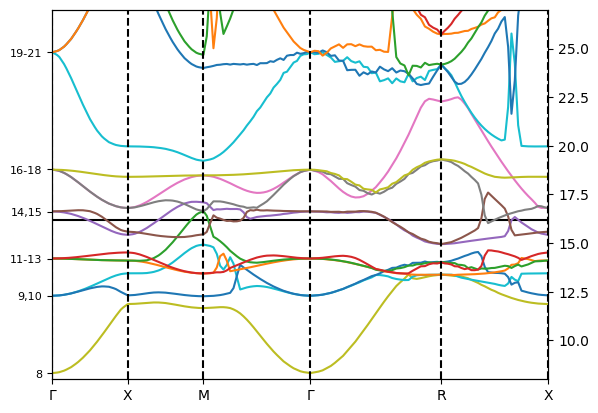

In [6]:
# flood fill from gamma point
# for that, define a graph that connects close k-points
# since all k_points in cubic symmetry have the same distance from all their neighbors,
# figure out the closest points to the gamma point and then connect everything with that distance.
# This also works for hexagonal symmetry if limit = 2 and more
limit = 1

d = np.round(np.linalg.norm(k_smpl, axis=-1), 6)
d = sorted(set(d))
print(d[:6])
limit_d = d[limit] + 1e-5 # increase the limit a little to correct for rounding error

kdtree = KDTree(k_smpl_full)
dist, j = kdtree.query([0, 0, 0], k=20, distance_upper_bound=d[4] + 1e-5)
print("close to zero indices", list(set(order[j])))

# match projections and band energy together
match_values = np.concatenate([projections, ref_bands[...,None]], axis=-1)
# start at the gamma point
band_id = np.zeros(ref_bands.shape, dtype=np.int32) - 1
start = 1
wavefront = set([start])
band_id[start] = np.arange(len(ref_bands[0]))
used = set()
count_covered = 1
while len(wavefront):
    for i in wavefront:
        used.add(i)
    # find all close points to the wavefront
    new_wavefront = set()
    for i in wavefront:
        dist, j = kdtree.query(k_smpl[i], k=16, distance_upper_bound=limit_d)
        j = list(set([order[j] for d, j in zip(dist, j) if d > 0 and j >= 0 and j < len(k_smpl_full)]))
        j = [j for j in j if j not in new_wavefront and j not in used]
        for j in j:
            # i to j matching
            #print(f"{i} -> {j}")
            # for each band index in j, find the band index in i
            # copy the band id of the i bands to the corresponding j bands
            j_to_i = matching(match_values[j], match_values[i])
            band_id[j] = band_id[i][j_to_i]
            #print(k_smpl[i] - k_smpl[j])
            #print(matching(projections[i], projections[j]))
            #print(np.abs(projections[i, band_id[i], 0]))
            #print(np.abs(projections[j, band_id[j], 0]))
            #print()
            count_covered += 1
            new_wavefront.add(j)
    wavefront = new_wavefront
print(f"{count_covered}/{len(k_smpl)}")
print("complete:", not np.any(band_id == -1))
# band_ids must be converted to a reordering, that sorts the ids
band_ordering = np.zeros_like(band_id)
for i in range(len(band_id)):
    band_ordering[i][band_id[i]] = np.arange(len(band_id[0]))

from importlib import reload
reload(kpaths)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
ref_bands_full_ordered = np.take_along_axis(ref_bands_full, band_ordering[order], axis=1)
interpolator = kpaths.interpolate(k_smpl_full, ref_bands_full_ordered, Symmetry.none(), method='linear')
path.plot(interpolator, '-', label_bands="left", ylim=(8, 27))
plt.axhline(fermi_energy, color='k')
plt.show()